# Curve fitting
## 1. Introduction
If you perform linear regression on a sample and obtain a high $R^2$ value, it is possible that a model other than linear has a significantly higher $R^2$ value. It may be obvious when you plot the data, they may be linearly correlated for a limited range of values. Even if finding a good model can be a trial-and-error process, one should always attempt to justify the choice of a particular model on theoretical grounds.

## 2. Polynomial fitting
We saw linear regression (a polynomial of order 1) in another notebook. A quadratic model is a polynomial of order 2 and can be used if one expects an optimum value, with values increasing or decreasing around the optimum values. The next figure shows polynomials of order 2 and 3.

In [146]:
#import modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import t
from scipy.stats import f

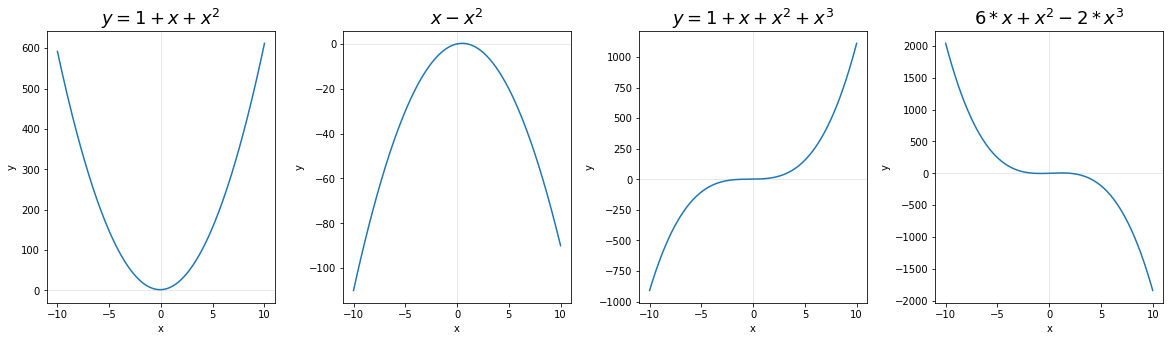

In [2]:
#draw polynomial curves
x = np.linspace(-10, 10, 200)
y_2 = 2 + x + 6 * x **2
y_2_minus = x - x **2
y_3 = 1 + x + x **2 + x **3
y_3_minus = 6 * x + x **2 - 2 * x **3

ys = [y_2, y_2_minus, y_3, y_3_minus]

labels = ["$y = 1 + x + x^2$", 
          "$x - x^2$", 
          "$y = 1 + x + x^2 + x^3$", 
          "$6 * x + x^2 - 2 * x^3$"]

fig, ax = plt.subplots(ncols=4, figsize=(20, 5))
for i in range(4):
    ax[i].axvline(x=0, color="lightgrey", lw=0.5)
    ax[i].axhline(y=0, color="lightgrey", lw=0.5)
    ax[i].plot(x, ys[i])
    ax[i].set_xlabel("x")
    ax[i].set_ylabel("y")
    ax[i].set_title(labels[i], fontsize=18)
plt.subplots_adjust(wspace=0.3)
plt.show()

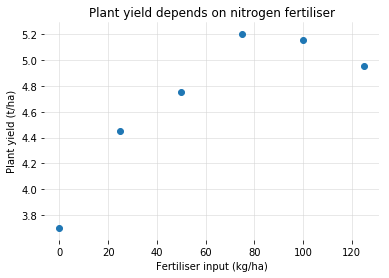

In [37]:
#data : plant yield depending on nitrogen fertilization
x = np.array([0, 25, 50, 75, 100, 125])
y = np.array([3.70, 4.45, 4.75, 5.20, 5.15, 4.95])

fig, ax = plt.subplots()
ax.scatter(x, y, zorder=4)
ax.set_xlabel('Fertiliser input (kg/ha)')
ax.set_ylabel('Plant yield (t/ha)')
ax.set_title('Plant yield depends on nitrogen fertiliser')
for axis in ['top', 'bottom', 'right', 'left']:
    ax.spines[axis].set_visible(False)
ax.grid(linewidth=0.5, color='lightgrey', zorder=3)

## 3. Quadratic regression

The yield data plotted above show that a quadratic curve may give a good fit, as yield increases to a maximum before decreasing when more nitrogen fertiliser is added. The mathematical equation for a quadratic (parabolic) curve is:

$$Y = \alpha + \beta_1X + \beta_2X^2$$

Estimates of the parameters are obtained and the fitted Y values are found using the following equation:

$$\hat{Y} = \hat{\alpha} + \hat{\beta_1}X + \hat{\beta_2}X^2$$

As usual, we calculate the residual sum of squares and the regression sum of squares:

$$ResidSS = \sum(Y - \hat{Y}^2$$
$$RegSS = \sum(Y - \bar{Y}) - ResidSS$$


The regression sum of squares for fitting and polynomial model of order p is always larger than when fitting a polynomial model of order p - 1, so $R^2$ will also be larger. To test if a parabola is a significantly better fit than a straight line we find the p-value for the parameter $\hat{\beta_2}$ with $(n - 3)$ degrees of freedom. The residual degrees of freedom are $(n-3)$ and must be at least 1 so there must be at least 4 different X values. In practice, more is recommended.

An alternative method to test if a parabola is a better fit than a straight line is to:
* fit a straight line and find the corresponding RegSS(Lin)
* fit a parabola and find the corresponding RegSS(Quad)
* calculate the variance ratio:

$$VR = \frac{RegSS(Quad) - RegSS(Lin)}{RMS(Quad)}$$

* calculate the p-value for VR with and F-distribution on $(1, \thinspace n-3)$ degrees of freedom

In [188]:
#define a parabola function
def parabola(x, a, b, c):
    return a + b * x + c * x ** 2

#function which performs a polynomial regression
#printed output for quadratic regression only
def poly_reg(func, x, y):
    
    #fit a polynomial curve on data
    #popt are optimal values for parameters
    #pcov are covariance of popt
    popt, pcov = curve_fit(func, x, y)
    
    #sample size
    n = len(x)
    
    #number of regression parameters
    p = len(popt)
    
    #=============#
    #=== ANOVA ===#
    #=============#
    #total sum of squares
    syy = np.sum([(yval - y.mean()) ** 2 for yval in y])

    #fitted y values
    y_hat = np.array([func(x, *popt)]).flatten()

    #residual sum of squares
    resid_ss = np.sum((y - y_hat) ** 2)

    #regression sum of squares
    reg_ss = syy - resid_ss
    
    #calculate total regression and residual mean squares
    total_ms = syy / (n - 1)
    reg_ms = reg_ss / (p - 1)
    resid_ms = resid_ss / (n - p)
    
    #calculate variance ratio and F-value
    vr = reg_ms / resid_ms
    p_val_f = 1 - f.cdf(vr, p - 1, n - p)
    
    #=======================#
    #=== GOODNESS OF FIT ===#
    #=======================#
    #calculate R-square and adjusted R-square
    R_sq = reg_ss / syy
    R_adj = (total_ms - resid_ms) / (total_ms)
    
    #sum of squares of x
    sxx = np.sum([(xval - x.mean()) ** 2 for xval in x])
    
    #standard error of intercept (not consistent with minitab output which is 0.08012)
    se_a = np.sqrt(resid_ms * (1 / n + x.mean() ** 2 / sxx))
    
    #standard error of coefficient b (not consistent with minitab output which is 0.003015)
    se_b = np.sqrt(resid_ms / sxx)
    
    #
    
    #calculate t-values for regression coefficients
    
    print("The regression equation is")
    print("Y = {0:.5f} {1:+.5f} * X {2:+.5f} * X^2\n".format(popt[0], popt[1], popt[2]))
    #print("{0:11}{1:>10}{2:>10}{3:>10}{4:>10}".format("", "Coef", "StDev", "t-value", "p-value"))
    #print("{0:11}{1:10.4f}{2:10.4f}{3:10.4f}{4:10.5f}".format("Intercept", a, SE_a, t_val_a, p_val_a))
    #print("{0:11}{1:10.4f}{2:10.4f}{3:10.4f}{4:10.5f}\n".format("Slope", b, SE_b, t_val_b, p_val_b))
    print("R-sq = {0:.1f}%, R-sq(adj) = {1:.1f}%\n".format(R_sq*100, R_adj*100))
    print("Analysis of variance")
    print("{0:15}{1:>10}{2:>10}{3:>10}{4:>10}{5:>10}".format("Source", "df", "Sum sq", "Mean sq", "F-value", "p-value"))
    print("{0:15}{1:10}{2:10.3f}{3:10.4f}{4:10.3f}{5:10.5f}".format("Regression", p - 1, reg_ss, reg_ms, vr, p_val_f))
    print("{0:15}{1:10}{2:10.3f}{3:10.4f}".format("Residual error", n - p, resid_ss, resid_ms))
    print("{0:15}{1:10}{2:10.3f}\n".format("Total", n - 1, syy))
    
    #=================#
    #=== PLOT DATA ===#
    #=================#
    fig, ax = plt.subplots()
    
    #plot actual data
    ax.scatter(x, y, zorder=5, label='Observed')
    
    #plot fitted data
    xx = np.linspace(min(x) - 1, max(x) + 1)
    y_fit = func(xx, *popt)
    ax.plot(xx, y_fit, color='C3', zorder=4, label='Fitted')
    
    #adjut visualisation
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Polynomial regression')
    for axis in ['top', 'bottom', 'right', 'left']:
        ax.spines[axis].set_visible(False)
    ax.grid(linewidth=0.5, color='lightgrey', zorder=3)

The regression equation is
Y = 3.70536 +0.03202 * X -0.00018 * X^2

R-sq = 98.5%, R-sq(adj) = 97.5%

Analysis of variance
Source                 df    Sum sq   Mean sq   F-value   p-value
Regression              2     1.557    0.7783    99.581   0.00181
Residual error          3     0.023    0.0078
Total                   5     1.580



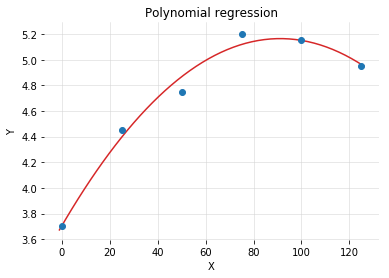

In [189]:
poly_reg(parabola, x, y)

### Quadratic response of y to x

For a quadratic curve, Y is a maximum when:
$$X = -\frac{\beta_1}{2\beta_2}$$

Let's calculate the optimal nitrogen fertiliser amount for a maximum yield.

In [152]:
#calculate optimal x value to maximize y value
popt = poly_reg(parabola, x, y)
x_opt = - popt[1] / 2 / popt[2]
print('The optimal yield is obtained with {:.2f} kg/ha of nitrogen.'.format(x_opt))

The optimal yield is obtained with 91.12 kg/ha of nitrogen.
